# Multimodal Transformer Model - MOSI

In this notebook, we implement the MulT Model (Multimodal Transformer for Unaligned Multimodal Language Sequences), and test it on CMU-MOSI dataset.

## Importing Libraries

In [1]:
import os
import sys
import torch

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

## Importing Helper Functions

In [2]:
from helpers.data.get_data import get_dataloader
from helpers.unimodals.common_models import Identity, MLP
from helpers.fusions.mult import MULTModel
from helpers.fusions.common_fusions import Concat
from helpers.training.supervised_learning import train, test
from helpers.utils.common_utils import get_default_device, save_results

## Loading the Dataset

In [3]:
traindata, validdata, testdata = get_dataloader('/scratch/rrm9598/data/mosi_data.pkl', robust_test=False, max_pad=True)

In [4]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [5]:
class HParams():
    num_heads = 8
    layers = 4
    attn_dropout = 0.1
    attn_dropout_modalities = [0, 0, 0.1]
    relu_dropout = 0.1
    res_dropout = 0.1
    out_dropout = 0.1
    embed_dropout = 0.2
    embed_dim = 40
    attn_mask = True
    output_dim = 1
    all_steps = False

In [6]:
encoders = [
    Identity().to(device), 
    Identity().to(device), 
    Identity().to(device)
]

fusion = MULTModel(3, [20, 5, 300], hyp_params=HParams).to(device)

head = Identity().to(device)

## Training

In [7]:
FILE_NAME = 'mosi_mult_r0'

In [8]:
train_losses, valid_losses = train(
    encoders, fusion, head, traindata, validdata, 100, 
    task="regression", optimtype=torch.optim.AdamW, early_stop=False, is_packed=False, 
    lr=1e-3, clip_val=1.0, save=f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt', 
    weight_decay=0.01, objective=torch.nn.L1Loss())

Epoch [1/100]
Train Loss: 1.4333
Valid Loss: 1.3701
Saving Best

Epoch [2/100]
Train Loss: 1.1188
Valid Loss: 1.2246
Saving Best

Epoch [3/100]
Train Loss: 0.9708
Valid Loss: 1.0582
Saving Best

Epoch [4/100]
Train Loss: 0.9027
Valid Loss: 1.0905

Epoch [5/100]
Train Loss: 0.8551
Valid Loss: 1.0067
Saving Best

Epoch [6/100]
Train Loss: 0.8109
Valid Loss: 1.0238

Epoch [7/100]
Train Loss: 0.7728
Valid Loss: 0.9285
Saving Best

Epoch [8/100]
Train Loss: 0.7213
Valid Loss: 1.0268

Epoch [9/100]
Train Loss: 0.7487
Valid Loss: 1.1480

Epoch [10/100]
Train Loss: 0.7295
Valid Loss: 0.9834

Epoch [11/100]
Train Loss: 0.6909
Valid Loss: 0.9648

Epoch [12/100]
Train Loss: 0.6707
Valid Loss: 1.0346

Epoch [13/100]
Train Loss: 0.6571
Valid Loss: 0.9122
Saving Best

Epoch [14/100]
Train Loss: 0.6843
Valid Loss: 0.9369

Epoch [15/100]
Train Loss: 0.6172
Valid Loss: 0.9335

Epoch [16/100]
Train Loss: 0.6266
Valid Loss: 0.9503

Epoch [17/100]
Train Loss: 0.6109
Valid Loss: 0.9586

Epoch [18/100]
Trai

Text(0.5, 1.0, 'Loss vs. No. of epochs')

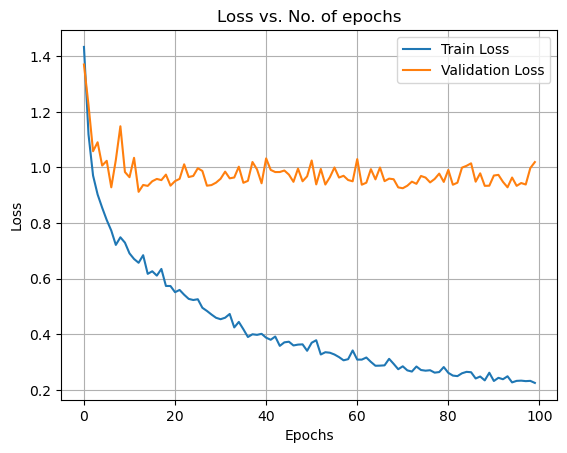

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [10]:
save_results(train_losses, valid_losses, f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/results/{FILE_NAME}.pkl')

## Testing

In [11]:
model = torch.load(f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt').to(device)

test(model, test_dataloaders_all=testdata, dataset='mosi', is_packed=False,
     criterion=torch.nn.L1Loss(), task='posneg-classification', no_robust=True)

Recall: 76.6768% | Total Accuracy: 75.0729%
Inference Time: 1s484ms
Inference Params: 3076961
